In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from sklearn.neighbors import NearestNeighbors
from numba import jit
from scipy import sparse
import pandas as pd

In [1]:
df = pd.read_csv('combined_peaks_named.csv')
df

NameError: name 'pd' is not defined

In [68]:
test_points = [
    [5167.89, 1.624, 154], # Biphynel
    [4078.14, 2.225, 128], # Naphtalene
    [6692.13, 2.040, 178], # Phenanthrene
    [6727.17, 2.019, 178], # Anthracene
    [5626.91, 1.600, 154], # Acenaphthene
    [7708.29, 2.344, 204], # Naphthalene, 1-phenyl-
    [7690.77, 2.704, 202], # Pyrene
    [7550.61, 2.624, 202] # Fluoranthene
]

In [69]:
# Phenanthrene max intesity 4025950.65 Orgueil
# Anthracene max intesity 28871.22 Green River Shale
# Acenaphthene max intesity 5006274.52 LEW85311
# Naphthalene, 1-phenyl- max intesity 436632.53 Green_River_Shale_Soil
# Pyrene max intesity X
# Fluoranthene max intesity 2329606.53 LEW85311


In [108]:
idx = 6
s = df[(df['RT1_center'] >= test_points[idx][0] - 50) & (df['RT1_center'] <= test_points[idx][0] + 50) 
&  (df['RT2_center'] >= test_points[idx][1] - 1) & (df['RT2_center'] <= test_points[idx][1] + 1)]

# s = df[ (df['RT1_center'] >= 8755.98 - 100) & (df['RT1_center'] <= 8755.98 + 100)
# & (df['RT2_center'] >= 1.7 - 1) & (df['RT2_center'] <= 1.7 + 1)
# & (df['m/z'] >= 228 - 10) & (df['m/z'] <= 228 + 10)]

# df[(df['m/z'] >= 202 - 2) & (df['m/z'] <= 202 + 2)]
s


,csv_file_name,peak_area,RT1_center,RT2_center,RT1_start,RT2_start,RT1_end,RT2_end,m/z,sample_name,class
88,230901_08_LEW85311_300uLDCM_100oC24h.csv,2366276.75,7641.712,2.24,7641.712,2.288,7645.216,2.184,208,LEW85311,0
665,230901_08_LEW85311_300uLDCM_100oC24h.csv,181958.23,7641.712,2.24,7641.712,2.288,7645.216,2.184,161,LEW85311,0
686,230901_08_LEW85311_300uLDCM_100oC24h.csv,408969.41,7641.712,2.24,7641.712,2.280,7641.712,2.192,163,LEW85311,0
849,230901_08_LEW85311_300uLDCM_100oC24h.csv,391899.49,7641.712,2.24,7641.712,2.296,7645.216,2.176,164,LEW85311,0


In [3]:
def gradient_calculator_gaussian_kde(x, data, bandwidth):
    D = data.shape[1]
    N = data.shape[0]
    grad = np.zeros((1, D))

    h = bandwidth

    C = 1/(N*h**D * np.sqrt(2*np.pi)**D)
    F = -1/(2*h**2)
    for i in range(D):
        for n in range(N):
            grad[0, i] += 2 * C * F * (x[i] - data[n, i]) * np.exp(F * np.sum((x - data[n])**2))
    
    return grad

In [14]:
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import numpy as np
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

df1 = df[df['class'] == 0].copy()
df2 = df[df['class'] == 1].copy()

# Append the new row to df1 using pd.concat
# df1 = pd.concat([df1, Naphtalene,Biphenyl], ignore_index=True)


features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

# Normalize all features
scaler = StandardScaler()
scaler.fit(features_all)
biotic_peaks_normalized = scaler.transform(features_class1_)
abiotic_peaks_normalized = scaler.transform(features_class0_)


# Define the bandwidth values to test
bandwidths = np.linspace(0.1, 1.0, 30)

# Set up the grid search
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation

# Fit the grid search
grid.fit(biotic_peaks_normalized)

# Get the best bandwidth
best_bandwidth = grid.best_estimator_.bandwidth
print(f"Best bandwidth: {best_bandwidth}")

# Fit KDE with the best bandwidth
kde = KernelDensity(bandwidth=best_bandwidth, kernel='gaussian')
kde.fit(biotic_peaks_normalized)
best_bandwidth

Best bandwidth: 0.19310344827586207


0.19310344827586207

In [15]:
test_points = [
    [5167.89, 1.624, 154], # Biphynel
    [4078.14, 2.225, 128], # Naphtalene
    [6692.13, 2.040, 178], # Phenanthrene
    [6727.17, 2.019, 178], # Anthracene
    [5626.91, 1.600, 154], # Acenaphthenes
    [7708.29, 2.344, 204]] # Naphthalene, 1-phenyl-

test_points = np.array(test_points)
test_points_normalized = scaler.transform(test_points)
test_points_normalized

array([[-1.05618736,  0.22735635, -0.375662  ],
       [-1.60111469,  1.64129193, -0.61938391],
       [-0.29399417,  1.20605386, -0.15068793],
       [-0.27647249,  1.15664845, -0.15068793],
       [-0.82665532,  0.17089303, -0.375662  ],
       [ 0.21413462,  1.92125589,  0.09303398]])

<Axes: ylabel='Count'>

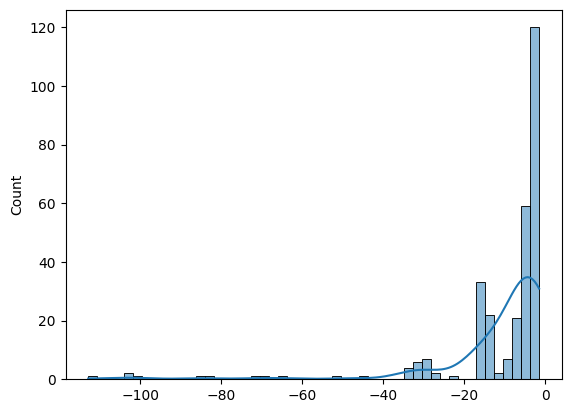

In [16]:
import seaborn as sns
sns.histplot(kde.score_samples(abiotic_peaks_normalized), bins=50, kde=True)

In [18]:
log_probs_biotic = kde.score_samples(test_points_normalized)
print(log_probs_biotic[0] - log_probs_abiotic[0],'Biphenyl')
print(log_probs_biotic[1] - log_probs_abiotic[1],'Naphtalene')
print(log_probs_biotic[2] - log_probs_abiotic[2],'Phenanthrene')
print(log_probs_biotic[3] - log_probs_abiotic[3],'Anthracene')
print(log_probs_biotic[4] - log_probs_abiotic[4],'Acenaphthenes')
print(log_probs_biotic[5] - log_probs_abiotic[5],'Naphthalene, 1-phenyl-')

-0.7923622807269575 Biphenyl
-13.59208145575323 Naphtalene
-1.322407100879416 Phenanthrene
-1.6166637627429203 Anthracene
-0.23501252696410146 Acenaphthenes
0.11215568777978957 Naphthalene, 1-phenyl-


In [28]:
import multiprocessing as mp
from functools import partial

def parallel_gradient_calculation(features, biotic_peaks_normalized, best_bandwidth):
    with mp.Pool() as pool:
        gradient_calculator = partial(gradient_calculator_gaussian_kde, 
                                      data=biotic_peaks_normalized, 
                                      bandwidth=best_bandwidth)
        gradients = pool.map(gradient_calculator, features)
    return np.array(gradients).reshape(-1, 3)

In [29]:
# 'Learning' rate - controls how influential gradients are
alpha = 1e-3

gradients_at_time_t = []

points_at_time_t = []

# Initialization

features = abiotic_peaks_normalized.copy()

time_steps = 50
for t in range(time_steps):
    # Compute gradient and move in that direction
    gradients = parallel_gradient_calculation(features, biotic_peaks_normalized, best_bandwidth = best_bandwidth)

    # Prevent exploding gradients due to approximation error
    # gradients = np.clip(gradients, -1, 1)

    # normalize gradients
    gradients_normalized = gradients / np.linalg.norm(gradients, axis=1)[:, None]

    features += (alpha) * gradients_normalized

    # Update new feature locations
    points_at_time_t.append(scaler.inverse_transform(features))

    gradients_at_time_t.append(gradients * scaler.scale_)
    if t % 10 == 0:
        print('Step ', t)

Step  0
Step  10
Step  20
Step  30
Step  40


1.6 93.72346666666667 155 1.6139944764018312 94.52600542119629 154.56615333682012
0.013994476401831157 0.8025387545296212 -0.4338466631798781


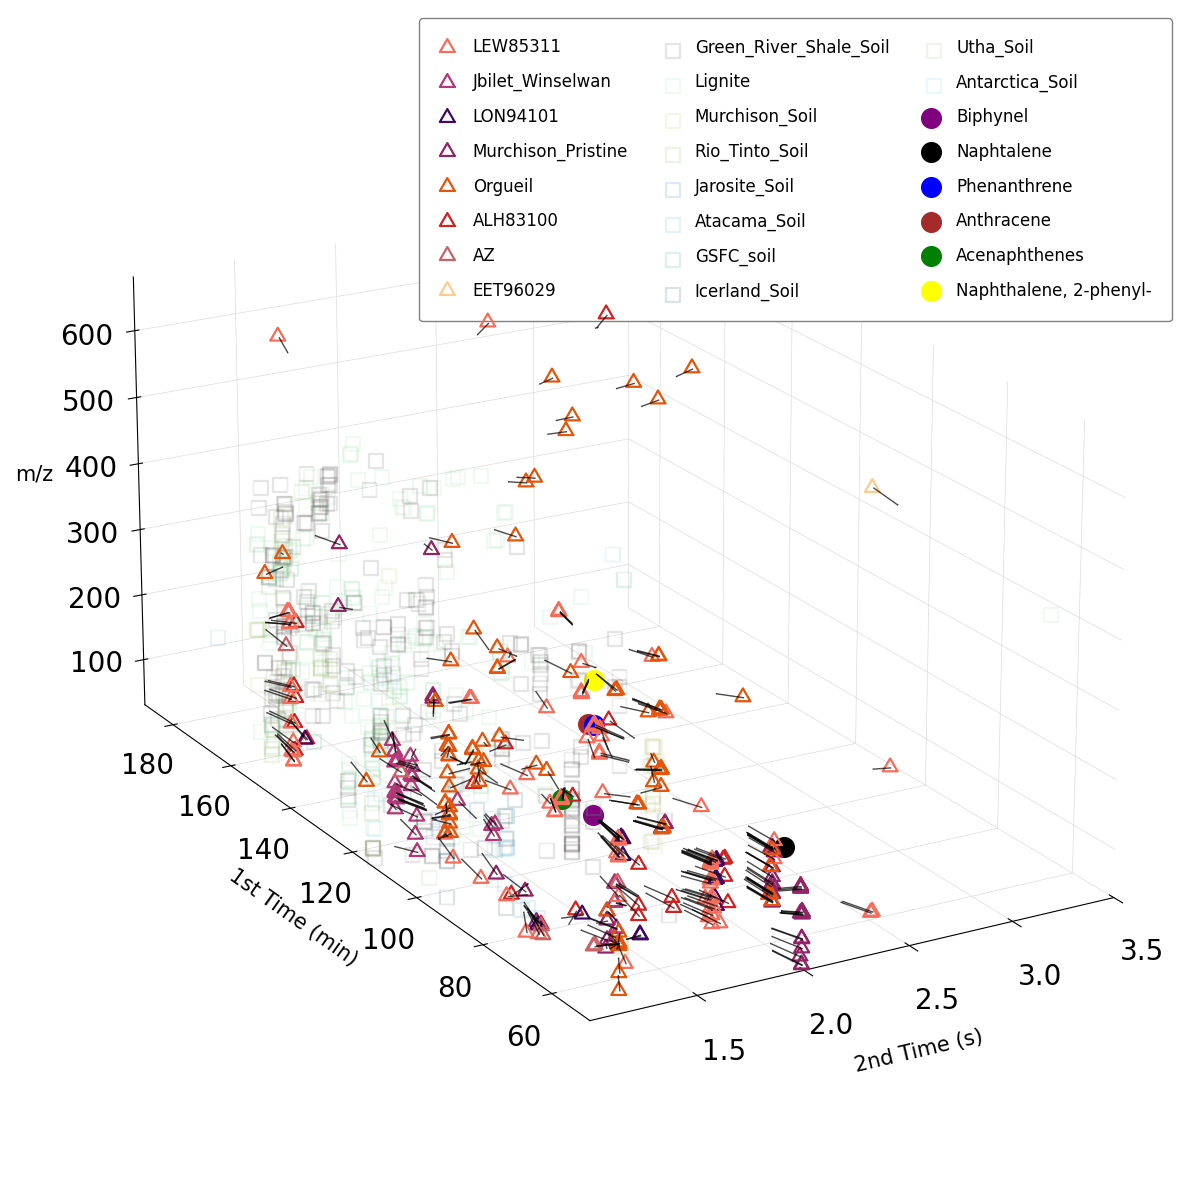

In [41]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import random
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.markers import MarkerStyle

def get_marker(svg_path):
    cwd = os.getcwd()
    custom_path, attributes = svg2paths(svg_path)
    marker = parse_path(attributes[0]['d'])
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

def plot_peak_gradients(peaks_features_df,df1, df2, dest_points, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    X_colors = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",]

    # Plot each class
    for class_id, markers, colors in zip([0, 1,-1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = updated_df[updated_df['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.1
                colors = colors_biotic
            elif class_id == 0:
                alpha = 1
                colors = colors_abiotic
            else:
                alpha = 1
                colors = X_colors
            if class_id == 1:
                size = 200
            elif class_id == 0:
                size = 200
            else:
                size = 400

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'] / 60.0,
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )
    
    ax.scatter(
        1.624,
        5167.89 / 60.0,
        154,
        c='purple',
        marker='o',
        s=200,
        alpha=1,
        label=f'Biphynel'
    )
    ax.scatter(
        2.225,
        4078.14 / 60.0,
        128,
        c='black',
        marker='o',
        s=200,
        alpha=1,
        label=f'Naphtalene'
    )

    ax.scatter(
        2.040,
        6692.13/ 60.0,
        178,
        c='blue',
        marker='o',
        s=200,
        alpha=1,
        label=f'Phenanthrene'
    )

    ax.scatter(
        2.019,
        6727.17 / 60.0,
        178,
        c='brown',
        marker='o',
        s=200,
        alpha=1,
        label=f'Anthracene'
    )

    ax.scatter(
        1.600,
        5626.91 / 60.0,
        154,
        c='green',
        marker='o',
        s=200,
        alpha=1,
        label=f'Acenaphthenes'
    )

    ax.scatter(
        2.200,
        7287.81 / 60.0,
        204,
        c='yellow',
        marker='o',
        s=200,
        alpha=1,
        label=f'Naphthalene, 2-phenyl-'
    )

    # quiver_kwargs = dict(length=5.0, normalize=False, colors="black", linewidth=1, edgecolors='k', alpha=0.7)
    print(df1['RT2_center'].iloc[0], df1['RT1_center'].iloc[0] / 60.0, df1['m/z'].iloc[0],dest_points[0, 1], dest_points[0, 0] / 60.0, dest_points[0, 2])
    print( dest_points[0, 1]-df1['RT2_center'].iloc[0], dest_points[0, 0] / 60.0 - df1['RT1_center'].iloc[0] / 60.0, dest_points[0, 2]-df1['m/z'].iloc[0])
    ax.quiver(
        df1['RT2_center'], df1['RT1_center'] / 60.0, df1['m/z'],
        dest_points[:, 1]-df1['RT2_center'], dest_points[:, 0] / 60.0 - df1['RT1_center'] / 60.0, dest_points[:, 2]-df1['m/z'], color='black', alpha=0.7, linewidth=1, edgecolors='k',
        length=5, arrow_length_ratio=0.01
    )


    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    ax.set_ylim(peaks_features_df['RT1_center'].min() / 60.0, 190)
    ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.savefig('peak_gradients_figure.pdf', dpi=300)
    plt.show()
    plt.close()

df1_updated = df1.copy()
# df1_updated['RT1_center'] = abiotic_peaks_normalized[:, 0]
# df1_updated['RT2_center'] = abiotic_peaks_normalized[:, 1]
# df1_updated['m/z'] = abiotic_peaks_normalized[:, 2]

df2_updated = df2.copy()
# df2_updated['RT1_center'] = biotic_peaks_normalized[:, 0]
# df2_updated['RT2_center'] = biotic_peaks_normalized[:, 1]
# df2_updated['m/z'] = biotic_peaks_normalized[:, 2]

updated_df = pd.concat([df1_updated, df2_updated], axis=0)

plot_peak_gradients(updated_df,df1,df2, points_at_time_t[40], '/content/', view='small')


In [122]:
def plot_peaks(peaks_features_df, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    # Plot each class
    for class_id, markers, colors in zip([0, 1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = updated_df[updated_df['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.23
                colors = colors_biotic
            else:
                alpha = 0.9
                colors = colors_abiotic
            if class_id == 1:
                size = 200
            else:
                size = 200

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'],
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )

    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    # ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    #ax.set_ylim(peaks_features_df['RT1_center'].min(), 190)
    # ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.title(result_dir)
    plt.savefig(result_dir)
    # plt.show()
    plt.close()


updated_df1 = df1.copy()
updated_df2 = df2.copy()
# combine
updated_df = pd.concat([updated_df1, updated_df2], axis=0)

# Remove if already exists
import os
import shutil
shutil.rmtree('timesteps', ignore_errors=True)
# Make directory
os.makedirs('timesteps', exist_ok=True)

plot_peaks(updated_df, f'timesteps/0.png', view='small')

for time_step in range(100):
    updated_df1 = df1.copy()
    updated_df1['RT1_center'] = points_at_time_t[time_step][:, 0]
    updated_df1['RT2_center'] = points_at_time_t[time_step][:, 1]
    updated_df1['m/z'] = points_at_time_t[time_step][:, 2]

    updated_df2 = df2.copy()

    # combine
    updated_df = pd.concat([updated_df1, updated_df2], axis=0)

    plot_peaks(updated_df, f'timesteps/{time_step+1}.png', view='small')

In [92]:
import os
from PIL import Image

# Define the directory containing the images
image_directory = "timesteps/"
output_gif_path = "output.gif"

time_steps = 100  # Number of images

# Load the images
images = [Image.open(f'{image_directory}{time_step}.png') for time_step in range(time_steps+1)]

# Create the GIF with slow transitions
gif_path = "output.gif"
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    duration=50,  # Duration in milliseconds for each frame
    loop=0
)

print(f"GIF saved to {gif_path}")

GIF saved to output.gif


In [298]:
time_steps

100

In [1]:
import os
# List all files in the directory
path = '/usr/scratch/NASA/results/'
files = os.listdir(path)
files

['230823_01_Atacama_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_02_Rio_Tinto_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_03_Murchison_Pristine_2.0_300uLDCM_100oC24h_Result.csv',
 '230823_04_Murchison_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_05_Antarctica_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_06_Jarosite_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_07_Green_River_Shale_Soil_500uLDCM_100oC24h_Result.csv',
 '230830_01_EET96029_300uLDCM_100oC24h_Result.csv',
 '230830_02_Orgueil_300uLDCM_100oC24h_Result.csv',
 '230830_03_Lignite_300uLDCM_100oC24h_Result.csv',
 '230901_05_GSFC_soil_300uLDCM_100oC24h_Result.csv',
 '230901_06_ALH83100_300uLDCM_100oC24h_Result.csv',
 '230901_07_LON94101_300uLDCM_100oC24h_Result.csv',
 '230901_08_LEW85311_300uLDCM_100oC24h_Result.csv',
 '231003_01_AZ_400uLDCM_100oC24h_Result.csv',
 '231003_01_DCM_Blank_300uLDCM_100oC24h_Result.csv',
 '231003_02_Jbilet_Winselwan_300uLDCM_100oC24h_Result.csv',
 '231003_03_Utha_Soil_300uLDCM_100oC24h_Result.csv',
 '231

In [2]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [90]:
# Function to find similar names
def find_similar_names(df, target_name, column_name='Name', threshold=80):
    results = process.extractBests(target_name, df[column_name], score_cutoff=threshold)
    return pd.DataFrame(results, columns=[column_name, 'score','Another_score'])

In [5]:
df.columns

Index(['Name', 'R.T. (s)', 'Type', 'Base Mass', 'Concentration',
       'Sample Concentration', 'Match', 'Quant Masses', 'Quant S/N', 'Area',
       'Integration Modified', 'Quantitation Analyte',
       '1st Dimension Time (s)', '2nd Dimension Time (s)', 'Actual Masses',
       'Analyte Id', 'Area %', 'CAS', 'Contributor', 'FWHH (s)', 'Formula',
       'InChIKey', 'IntegrationBegin', 'IntegrationEnd', 'Library',
       'LibraryId', 'Mass Difference', 'Non-Saturated Apex (s)',
       'Observed Ion m/z', 'Peak Number', 'Peak S/N', 'Probability',
       'Similarity', 'Retention Index', 'Mass Delta (mDa)',
       'Mass Accuracy (ppm)', 'Height', 'Spectrum'],
      dtype='object')

In [8]:
import pandas as pd

for file in files:
    # file = '230823_03_Murchison_Pristine_2.0_300uLDCM_100oC24h_Result.csv'
    df = pd.read_csv(path + file, encoding='latin1')

    # Search for rows that contain 'PHENYLNAPHTHALENE'
    # df['name'] = df['Name'].str.upper()

    # similar_names = find_similar_names(df, 'benz(a)anthracene')
    # similar_names = df[(df['Name'].str.contains('Benzophenanthrene'.upper()))]

    # mz = 204.27
    rt1 = 9856.24
    rt2 = 1.08
    # similar_names = df[(df['Base Mass'] < mz+0.5) & (df['Base Mass'] > mz-0.5)]
    similar_names = df[(df['1st Dimension Time (s)'] < rt1+50) & (df['1st Dimension Time (s)'] > rt1-50) & (df['2nd Dimension Time (s)'] < rt2+1) & (df['2nd Dimension Time (s)'] > rt2-1)]

    if len(similar_names) > 0:
        print(f"File: {file} - Similar names:")
        print(len(similar_names))
        print('--'*20)

    

File: 230823_01_Atacama_Soil_300uLDCM_100oC24h_Result.csv - Similar names:
134
----------------------------------------
File: 230823_02_Rio_Tinto_Soil_300uLDCM_100oC24h_Result.csv - Similar names:
145
----------------------------------------
File: 230823_03_Murchison_Pristine_2.0_300uLDCM_100oC24h_Result.csv - Similar names:
145
----------------------------------------
File: 230823_04_Murchison_Soil_300uLDCM_100oC24h_Result.csv - Similar names:
145
----------------------------------------
File: 230823_05_Antarctica_Soil_300uLDCM_100oC24h_Result.csv - Similar names:
137
----------------------------------------
File: 230823_06_Jarosite_Soil_300uLDCM_100oC24h_Result.csv - Similar names:
123
----------------------------------------
File: 230823_07_Green_River_Shale_Soil_500uLDCM_100oC24h_Result.csv - Similar names:
238
----------------------------------------
File: 230830_01_EET96029_300uLDCM_100oC24h_Result.csv - Similar names:
116
----------------------------------------


/tmp/ipykernel_2887333/1319422605.py:5: DtypeWarning: Columns (9,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + file, encoding='latin1')


File: 230830_02_Orgueil_300uLDCM_100oC24h_Result.csv - Similar names:
150
----------------------------------------
File: 230830_03_Lignite_300uLDCM_100oC24h_Result.csv - Similar names:
214
----------------------------------------
File: 230901_05_GSFC_soil_300uLDCM_100oC24h_Result.csv - Similar names:
94
----------------------------------------
File: 230901_06_ALH83100_300uLDCM_100oC24h_Result.csv - Similar names:
94
----------------------------------------
File: 230901_07_LON94101_300uLDCM_100oC24h_Result.csv - Similar names:
74
----------------------------------------
File: 230901_08_LEW85311_300uLDCM_100oC24h_Result.csv - Similar names:
108
----------------------------------------
File: 231003_01_AZ_400uLDCM_100oC24h_Result.csv - Similar names:
71
----------------------------------------
File: 231003_01_DCM_Blank_300uLDCM_100oC24h_Result.csv - Similar names:
56
----------------------------------------
File: 231003_02_Jbilet_Winselwan_300uLDCM_100oC24h_Result.csv - Similar names:
63
-

In [13]:
file = '230823_02_Rio_Tinto_Soil_300uLDCM_100oC24h_Result.csv'
df = pd.read_csv(path + file, encoding='latin1')

rt1 = 9856.24
rt2 = 1.08
# similar_names = df[(df['Base Mass'] < mz+0.5) & (df['Base Mass'] > mz-0.5)]
similar_names = df[(df['1st Dimension Time (s)'] < rt1+100) & (df['1st Dimension Time (s)'] > rt1-100) & (df['2nd Dimension Time (s)'] < rt2+0.2) & (df['2nd Dimension Time (s)'] > rt2-0.2)]

similar_names

,Name,R.T. (s),Type,Base Mass,Concentration,Sample Concentration,Match,Quant Masses,Quant S/N,Area,...,Observed Ion m/z,Peak Number,Peak S/N,Probability,Similarity,Retention Index,Mass Delta (mDa),Mass Accuracy (ppm),Height,Spectrum
5422,"1,3,4,6-Tetrabromopentacyclo[9.3.1.1(6,10).0(3...","9768.64, 1.248",Unknown,91.0543,NaN,NaN,NaN,BPI(91.054295±5ppm),6.0,14606.0,...,91.0543,799.0,17.0,NaN,951.0,0.0,0.07,0.75,1384.0,44.97926:650.03 52.98430:356.21 61.00836:345.5...
5456,"3,3,5,5,9,9,11,11-Octamethyl-1,7-diphenylbicyc...","9824.7, 1.257",Unknown,91.0544,NaN,NaN,NaN,BPI(91.054376±5ppm),8.0,18905.0,...,91.0544,819.0,17.0,NaN,951.0,0.0,0.15,1.64,1582.0,57.06994:635.11 58.04134:465.43 59.04932:158.1...
5458,"SPIRO[2H-BENZ[F]INDENE-2,1'-[1H]INDENE]-1,3-DI...","9845.73, 1.264",Unknown,91.0543,NaN,NaN,NaN,BPI(91.054278±5ppm),7.0,17291.0,...,91.0543,821.0,18.0,NaN,928.0,0.0,0.05,0.56,1340.0,44.97920:656.40 88.95101:39.02 89.03879:43.29 ...
5460,"Benzo[h]-1,6-naphthyridin-2(1H)-one, 1-[4-[4-(...","9852.74, 1.264",Unknown,91.0542,NaN,NaN,NaN,BPI(91.054244±5ppm),8.0,19025.0,...,91.0542,823.0,18.0,NaN,928.0,0.0,0.02,0.19,1692.0,88.95092:153.78 91.05424:1000.00 103.96642:59....
5462,"2-NITRO-ß,ß-DIFLUORO-a-(TRIFLUOROMETHYL)STYRENE","9856.24, 0.992",Unknown,253.0160,NaN,NaN,NaN,BPI(253.016021±5ppm),7.0,12695.0,...,253.0160,825.0,26.0,NaN,745.0,0.0,-0.05,-0.18,1288.0,61.01028:344.42 102.96682:317.65 132.92288:128...
5464,n-Hexacosane,"9849.23, 1.056",Unknown,57.0700,NaN,NaN,NaN,BPI(57.069992±5ppm),24.0,58860.0,...,57.0700,827.0,35.0,NaN,992.0,0.0,0.11,2.01,5657.0,39.02299:81.06 41.03866:172.58 42.04648:29.11 ...
5465,n-Hexacosane,"9852.74, 1.048",Unknown,57.0699,NaN,NaN,NaN,BPI(57.069992±5ppm),86.0,244078.0,...,57.0700,827.0,137.0,NaN,992.0,0.0,0.11,2.01,23558.0,39.02299:81.06 41.03866:172.58 42.04648:29.11 ...
5466,n-Hexacosane,"9856.24, 1.042",Unknown,57.0700,NaN,NaN,NaN,BPI(57.069992±5ppm),206.0,665470.0,...,57.0700,827.0,302.0,NaN,992.0,0.0,0.11,2.01,59818.0,39.02299:81.06 41.03866:172.58 42.04648:29.11 ...
5467,n-Hexacosane,"9859.74, 1.046",Unknown,57.0700,NaN,NaN,NaN,BPI(57.069992±5ppm),222.0,711286.0,...,57.0700,827.0,334.0,NaN,992.0,0.0,0.11,2.01,64940.0,39.02299:81.06 41.03866:172.58 42.04648:29.11 ...
5468,n-Hexacosane,"9863.25, 1.040",Unknown,57.0700,NaN,NaN,NaN,BPI(57.069992±5ppm),130.0,371368.0,...,57.0700,827.0,166.0,NaN,992.0,0.0,0.11,2.01,32604.0,39.02299:81.06 41.03866:172.58 42.04648:29.11 ...


In [3]:
import numpy as np

np.load('/usr/scratch/chromalyzer/heatmaps/230823_01_Atacama_Soil_300uLDCM_100oC24h-001.csv/30_second_time.npy')

array([3.504, 3.496, 3.488, 3.48 , 3.472, 3.464, 3.456, 3.448, 3.44 ,
       3.432, 3.424, 3.416, 3.408, 3.4  , 3.392, 3.384, 3.376, 3.368,
       3.36 , 3.352, 3.344, 3.336, 3.328, 3.32 , 3.312, 3.304, 3.296,
       3.288, 3.28 , 3.272, 3.264, 3.256, 3.248, 3.24 , 3.232, 3.224,
       3.216, 3.208, 3.2  , 3.192, 3.184, 3.176, 3.168, 3.16 , 3.152,
       3.144, 3.136, 3.128, 3.12 , 3.112, 3.104, 3.096, 3.088, 3.08 ,
       3.072, 3.064, 3.056, 3.048, 3.04 , 3.032, 3.024, 3.016, 3.008,
       3.   , 2.992, 2.984, 2.976, 2.968, 2.96 , 2.952, 2.944, 2.936,
       2.928, 2.92 , 2.912, 2.904, 2.896, 2.888, 2.88 , 2.872, 2.864,
       2.856, 2.848, 2.84 , 2.832, 2.824, 2.816, 2.808, 2.8  , 2.792,
       2.784, 2.776, 2.768, 2.76 , 2.752, 2.744, 2.736, 2.728, 2.72 ,
       2.712, 2.704, 2.696, 2.688, 2.68 , 2.672, 2.664, 2.656, 2.648,
       2.64 , 2.632, 2.624, 2.616, 2.608, 2.6  , 2.592, 2.584, 2.576,
       2.568, 2.56 , 2.552, 2.544, 2.536, 2.528, 2.52 , 2.512, 2.504,
       2.496, 2.488,

In [2]:
2200-2203.504

-3.5039999999999054